In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# ==========================================
# Setup & Configuration
# ==========================================
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 3 # Small number of epochs as requested

# ==========================================
# Data Preparation (CIFAR-10)
# ==========================================
# ResNet-152 expects 224x224 input images for optimal performance with pre-trained weights.
# CIFAR-10 images are 32x32, so we resize them.
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet stats
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Download and load datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms['train'])
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ==========================================
# Step (a): Load Pre-trained ResNet-152
# ==========================================
print("Loading ResNet-152...")
# Using 'DEFAULT' uses the best available pre-trained weights (ImageNet)
model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

# ==========================================
# Step (c): Freeze Backbone (Train only head)
# ==========================================
# We do this BEFORE replacing the final layer so the new layer (step b) is NOT frozen.
for param in model.parameters():
    param.requires_grad = False

# ==========================================
# Step (b): Replace Classification Layer
# ==========================================
# ResNet's final layer is named 'fc'. We replace it with a new Linear layer.
# The new layer automatically has requires_grad=True by default.
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10) # CIFAR-10 has 10 classes

model = model.to(device)

# ==========================================
# Step (d): Train and Record Performance
# ==========================================
criterion = nn.CrossEntropyLoss()

# Important: Optimizer should only update parameters that require gradients
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs):
    history = {'train_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        print("-" * 10)

        # --- Training Phase ---
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)
        print(f"Train Loss: {epoch_loss:.4f}")

        # --- Validation Phase ---
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_acc = 100 * correct / total
        history['val_acc'].append(epoch_acc)
        print(f"Validation Accuracy: {epoch_acc:.2f}%")
        print()

    return history

# Run the training
history = train_and_validate(model, train_loader, val_loader, criterion, optimizer, EPOCHS)

Using device: cuda
Loading ResNet-152...
Epoch 1/3
----------
Train Loss: 0.6683
Validation Accuracy: 83.65%

Epoch 2/3
----------
Train Loss: 0.4960
Validation Accuracy: 84.45%

Epoch 3/3
----------
Train Loss: 0.4627
Validation Accuracy: 84.66%



**part 2**

In [4]:
import types # To modify methods at runtime

# 1. Reload the Baseline Model (Fresh start)
model_broken = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

# Freeze backbone
for param in model_broken.parameters():
    param.requires_grad = False

# Replace head for CIFAR-10
model_broken.fc = nn.Linear(model_broken.fc.in_features, 10)
model_broken = model_broken.to(device)

# 2. Define a "Broken" Forward Pass
# This function replicates the standard ResNet Bottleneck forward pass
# BUT removes the addition of the identity (residual).
def broken_forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
        identity = self.downsample(x)

    # ORIGINAL: out += identity
    # MODIFIED: Skip connection removed!
    # out += identity

    out = self.relu(out)
    return out

# 3. Surgically disable skip connections in specific layers
# We will target the middle layers (Layer 2 and 3) where feature transformation is critical.
# ResNet-152 has many blocks; we modify the first few blocks of layer 2.
print("Disabling skip connections in Layer 2 (Blocks 0-3)...")
layers_to_break = [model_broken.layer2[0], model_broken.layer2[1], model_broken.layer2[2]]

for block in layers_to_break:
    # Use MethodType to bind the function to the specific instance
    block.forward = types.MethodType(broken_forward, block)

# 4. Re-train the head
optimizer_broken = optim.Adam(filter(lambda p: p.requires_grad, model_broken.parameters()), lr=LEARNING_RATE)

print("\nTraining Modified ResNet (Broken Residuals)...")
history_broken = train_and_validate(model_broken, train_loader, val_loader, criterion, optimizer_broken, EPOCHS)

Disabling skip connections in Layer 2 (Blocks 0-3)...

Training Modified ResNet (Broken Residuals)...
Epoch 1/3
----------
Train Loss: 2.1647
Validation Accuracy: 22.60%

Epoch 2/3
----------
Train Loss: 2.1037
Validation Accuracy: 24.80%

Epoch 3/3
----------
Train Loss: 2.0869
Validation Accuracy: 24.07%



**part 3**

Visualizing Feature Hierarchies...


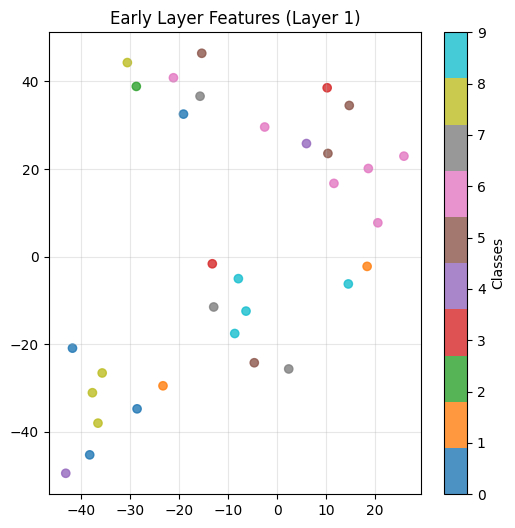

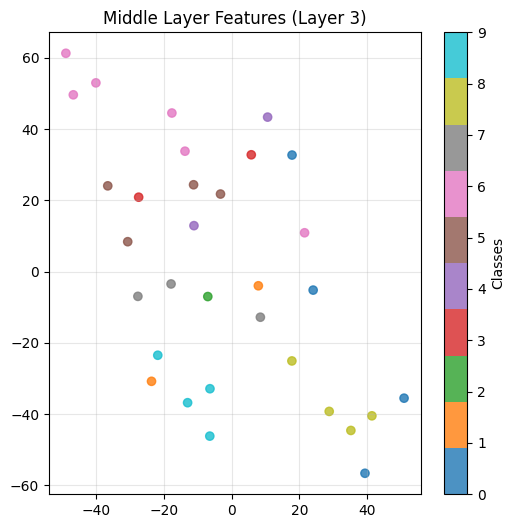

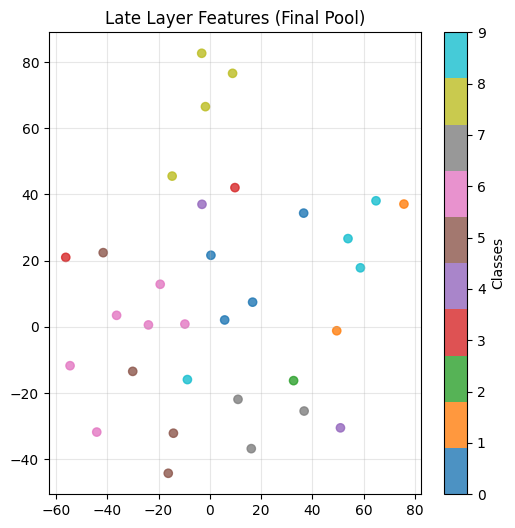

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 1. Setup Hooks to capture features
features = {}

def get_activation(name):
    def hook(model, input, output):
        # Detach from graph and move to CPU
        features[name] = output.detach().cpu()
    return hook

# Register hooks at specific layers:
# Layer 1 (Early): Low-level features (edges/colors)
# Layer 3 (Middle): Mid-level features (patterns/parts)
# AvgPool (Late): High-level semantic features (objects)
model.layer1.register_forward_hook(get_activation('early'))
model.layer3.register_forward_hook(get_activation('middle'))
model.avgpool.register_forward_hook(get_activation('late'))

# 2. Collect a batch of data for visualization
# We only need one batch (e.g., 32-64 images) to visualize clusters
dataiter = iter(val_loader)
images, labels = next(dataiter)
images = images.to(device)

# Forward pass to trigger hooks
model(images)

# 3. Process features for t-SNE
# t-SNE requires a 2D matrix (N_samples, N_features).
# We must flatten the spatial dimensions of the conv layers using Global Average Pooling.

def prepare_for_tsne(tensor_data):
    # Input shape: (Batch, Channels, H, W) or (Batch, Channels, 1, 1)
    if len(tensor_data.shape) > 2:
        # Perform Global Average Pooling: (B, C, H, W) -> (B, C)
        tensor_data = torch.mean(tensor_data, dim=[2, 3])
    return tensor_data.numpy()

early_feats = prepare_for_tsne(features['early'])
middle_feats = prepare_for_tsne(features['middle'])
late_feats = prepare_for_tsne(features['late'])

# 4. Compute t-SNE and Plot
def plot_tsne(features, labels, title):
    # Perplexity must be < n_samples. Since batch=32, we use perplexity=5 or 10
    tsne = TSNE(n_components=2, random_state=42, perplexity=5, init='pca', learning_rate='auto')
    projections = tsne.fit_transform(features)

    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(projections[:, 0], projections[:, 1], c=labels, cmap='tab10', alpha=0.8)
    plt.colorbar(scatter, label='Classes')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualize
print("Visualizing Feature Hierarchies...")

plot_tsne(early_feats, labels, "Early Layer Features (Layer 1)")
plot_tsne(middle_feats, labels, "Middle Layer Features (Layer 3)")
plot_tsne(late_feats, labels, "Late Layer Features (Final Pool)")

**part 4**

In [6]:
def setup_resnet_experiment(mode='pretrained_head_only'):
    # Initialize model
    if mode == 'random_init':
        # No weights = Random Initialization
        model = models.resnet152(weights=None)
    else:
        # Load ImageNet weights
        model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

    # Modify the final layer for CIFAR-10
    model.fc = nn.Linear(model.fc.in_features, 10)

    # Freeze/Unfreeze layers based on mode
    if mode == 'pretrained_head_only':
        # Freeze everything first
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze head (automatically unfrozen since we just created it, but explicit is good)
        for param in model.fc.parameters():
            param.requires_grad = True

    elif mode == 'fine_tune_block4':
        # Freeze everything first
        for param in model.parameters():
            param.requires_grad = False

        # Unfreeze ONLY Layer 4 (The last conv block) and the Head
        for param in model.layer4.parameters():
            param.requires_grad = True
        for param in model.fc.parameters():
            param.requires_grad = True

    elif mode == 'random_init':
        # Unfreeze everything (Standard training)
        for param in model.parameters():
            param.requires_grad = True

    return model.to(device)

# --- Execution ---
modes = ['random_init', 'fine_tune_block4']
results = {}

print("Starting Comparative Experiments...")

for mode in modes:
    print(f"\nRunning Experiment: {mode}")
    model_exp = setup_resnet_experiment(mode)

    # Note: Random Init requires lower LR and more epochs to converge,
    # but for this demo, we keep params constant to show the drastic difference.
    optimizer_exp = optim.Adam(filter(lambda p: p.requires_grad, model_exp.parameters()), lr=1e-4)

    # We run for just 2 epochs to demonstrate the initial convergence behavior
    hist = train_and_validate(model_exp, train_loader, val_loader, criterion, optimizer_exp, epochs=2)
    results[mode] = hist['val_acc'][-1]

print("\n--- Final Results (Validation Accuracy after 2 Epochs) ---")
print(f"Random Initialization: {results.get('random_init', 0):.2f}%")
print(f"Fine-Tune Block 4:     {results.get('fine_tune_block4', 0):.2f}%")

Starting Comparative Experiments...

Running Experiment: random_init
Epoch 1/2
----------
Train Loss: 1.7926
Validation Accuracy: 43.78%

Epoch 2/2
----------
Train Loss: 1.3980
Validation Accuracy: 52.98%


Running Experiment: fine_tune_block4
Epoch 1/2
----------
Train Loss: 0.4887
Validation Accuracy: 90.61%

Epoch 2/2
----------
Train Loss: 0.2263
Validation Accuracy: 91.25%


--- Final Results (Validation Accuracy after 2 Epochs) ---
Random Initialization: 52.98%
Fine-Tune Block 4:     91.25%


**part 5**

In [ ]:
!pip install umap-learn

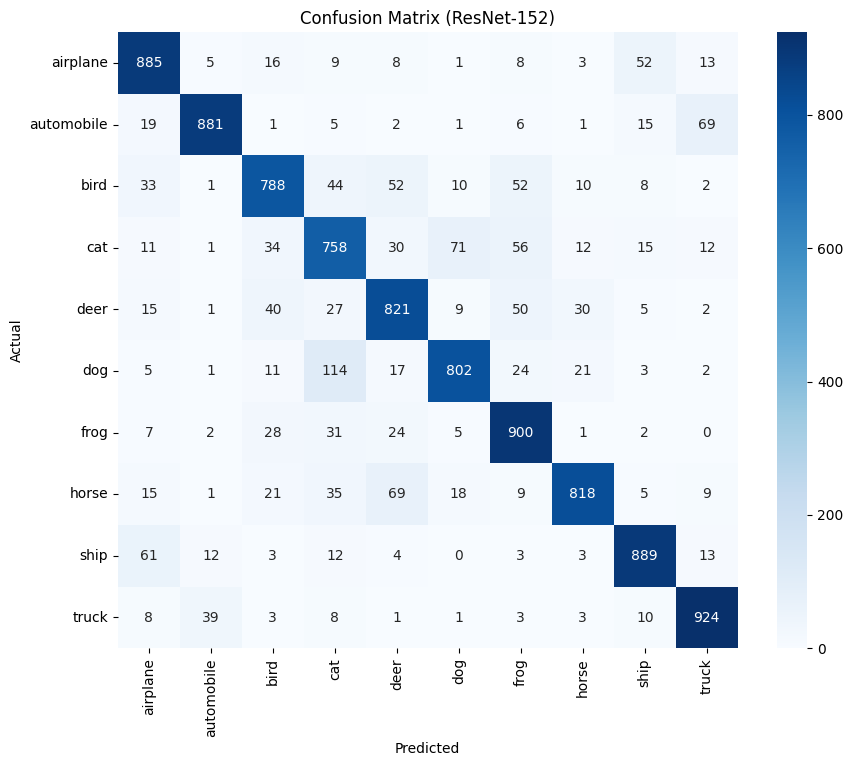


--- Comparative Study: ResNet-18 vs ResNet-152 ---
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


Epoch 1/1
----------
Train Loss: 0.8049
Validation Accuracy: 79.29%

ResNet-18 (1 Epoch) Val Acc: 79.29%


In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Confusion Matrix Analysis on ResNet-152
def plot_confusion_matrix(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix (ResNet-152)')
    plt.show()

# Run Confusion Matrix (using the best model from previous steps)
# Assuming 'model' is the fine-tuned ResNet-152
plot_confusion_matrix(model, val_loader)


# 2. Compare with Shallower Network (ResNet-18)
print("\n--- Comparative Study: ResNet-18 vs ResNet-152 ---")

# Load and prep ResNet-18
model_r18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model_r18.fc = nn.Linear(model_r18.fc.in_features, 10)
model_r18 = model_r18.to(device)

# Freeze backbone and train head (Quick comparison)
for param in model_r18.parameters():
    param.requires_grad = False
for param in model_r18.fc.parameters():
    param.requires_grad = True

optimizer_r18 = optim.Adam(model_r18.fc.parameters(), lr=1e-3)
hist_r18 = train_and_validate(model_r18, train_loader, val_loader, criterion, optimizer_r18, epochs=1)

print(f"ResNet-18 (1 Epoch) Val Acc: {hist_r18['val_acc'][-1]:.2f}%")
# Compare this value to the ResNet-152 baseline in Task 1